17.01.2021

### Image Processing in Physics
#### Julia Herzen, Klaus Achterhold, Clemens Schmid, Manuel Schultheiss

# Exercise 1: Iterative phase retrieval with Fraunhofer propagation

Perform iterative phase retrieval to **recover the phase at the
aperture plane** from
* the intensity at the focal plane and
* the known support magnitude in the aperture plane!

In [3]:
import numpy as np
import matplotlib.pylab as plt

%matplotlib inline
plt.rcParams["image.cmap"] = "gray"
plt.rcParams["image.interpolation"] = "none"

## The setup:

An aperture is illuminated with a field of constant magnitude and some spatial
variation of the phase. The field observed in the back focal plane of a lens
behind the aperture is determined by Fraunhofer diffraction (far-field regime).

The phase variation in the aperture plane is given as a sum of "tip" and "tilt" modes
(i.e. a linear ramp) to ensure fast convergence and avoid problems with phase wrapping,
twin images or piston offset in Part 2 of the exercise.

![title](fig_iterative2.png)

## Part 1: Calculate intensity on screen from field at aperture

Square dimensions of phase screen:

In [1]:
N = 512

Calculate the support constraint (magnitude at the aperture plane).

Generate a round mask and make sure that the radius is 128 pixels.

In [5]:
r = 128
y = np.arange(-N/2, N/2) + .5
x = np.arange(-N/2, N/2) + .5
yy, xx = np.meshgrid(x, y)
aperture = xx**2 + yy**2 <= r**2

Show your aperture function:

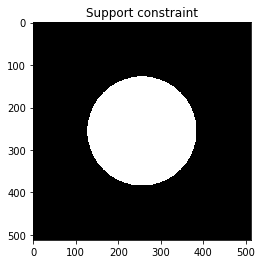

In [6]:
plt.figure()
plt.title('Support constraint')
plt.imshow(aperture)

Generate the tip & tilt zernikes:

In [7]:
y = np.arange(-N/2, N/2) + .5
x = np.arange(-N/2, N/2) + .5
yy, xx = np.meshgrid(y, x, indexing='ij')

tip = yy / np.max(yy) 
tilt = xx / np.max(xx)

Set the phase screen as a combination of tip and tilt:

In [8]:
screen = tip * 4. + tilt * 3.

Show aperture phase:

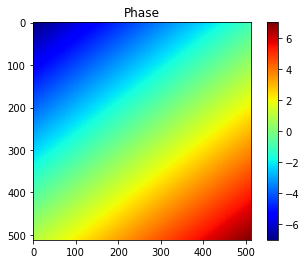

In [9]:
plt.figure()
plt.title("Phase")
plt.imshow(screen, cmap="jet")
plt.colorbar()

Calculate the scalar field at the focal plane from the scalar field at the phase screen
via Fraunhofer propagation.

Hints:
* ``aperture`` is the magnitude and ``screen`` is the phase of
  the (complex-valued) scalar field.
* You may need to use ``np.fft.fftshift`` here
* Intensity is the magnitude squared of the scalar field at the focal plane.

In [10]:
field_aperture = aperture * np.exp(1.j * screen)
field_focal_plane = np.fft.ifftshift(np.fft.fft2(field_aperture))

intensity_focal_plane = np.abs(field_focal_plane)**2

Plot the far-field image (zoomed in to show the centre), together with the input parameters (the field at the aperture):

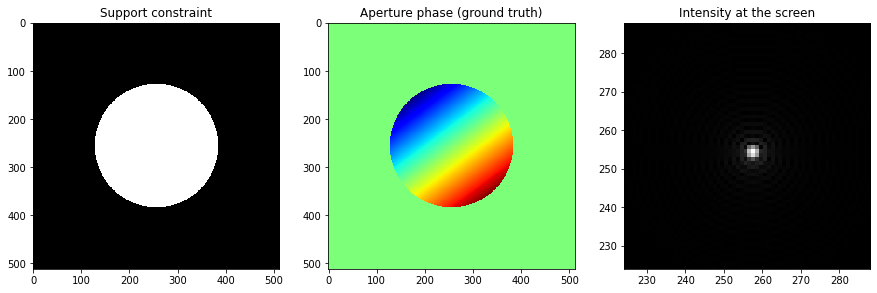

In [12]:
plt.figure(figsize=(15, 9))

plt.subplot(131)
plt.title('Support constraint')
plt.imshow(aperture, cmap='gray', interpolation='none');

plt.subplot(132)
plt.title('Aperture phase (ground truth)')
plt.imshow(screen * aperture, cmap='jet', interpolation='none')

plt.subplot(133)
plt.title('Intensity at the screen')
size = 64
left, right = (N - size) // 2, (N + size) // 2
plt.imshow(np.sqrt(intensity_focal_plane[left:right, left:right]), extent=[left,right,left,right])

## Part 2: Determine phase at aperture plane from intensity at the focal plane

Now, we use the type of calculation from Part 1 to solve the
"[phase problem](https://en.wikipedia.org/wiki/Phase_problem)":

In a real experiment, we know the intensity at the focal plane
and the shape of the aperture, and want to determine
the phase of the field at the aperture.

If the complex-valued field at the focal plane is known, the field at the aperture plane
can be easily determined by inverting the calculation from Part 1, i.e. by an *inverse*
Fourier transform of the field at the focal plane.

However, only the intensity, which is the magnitude squared of the complex-valued field,
is directly measurable. The phase of the field at the focal plane is thus unknown.

Therefore, we require a more complicated phase retrieval method:

We propagate backwards and forwards between the two planes (see Figure above), while
maintaining two constraints:
1. The magnitude squared of the field in the focal plane must be equal to the measured intensity
2. The magnitude of the field in the aperture plane must be zero outside of the aperture.

The approach is thus:
0. Guess a field in the focal plane
1. Apply constraint #1 to field in the focal plane
2. Propagate backwards to aperture plane
3. Apply constraint #2 to field in aperture plane
4. Propagate forwards to focal plane
5. Go to step 2.

This is repeated either for a fixed number of iterations (which is what we do)
or until the result (almost) doesn't change anymore.
Meanwhile, we also track the difference between
our guess for field magnitude and true magnitude.

Number of loops (iterations) to run the phase retrieval
If your code doesn't converge in < 50 iterations, there is something wrong! 

In [18]:
nloops = 50

Calculate the magnitude of the field, i.e. the square root of the intensity, at the focal plane from the previously determined intensity:

In [19]:
magnitude_focal_plane = np.sqrt(intensity_focal_plane)

Initial guess for the (complex-valued) scalar field at the focal plane:

In [20]:
field_focal_plane = magnitude_focal_plane * np.exp(1.j * np.zeros((N, N)))

Create empty arrays to store the values for the errors:

In [21]:
errors_aperture = np.zeros(nloops)
errors_focal = np.zeros(nloops)

Perform the iterative estimation of the phase map at the aperture:

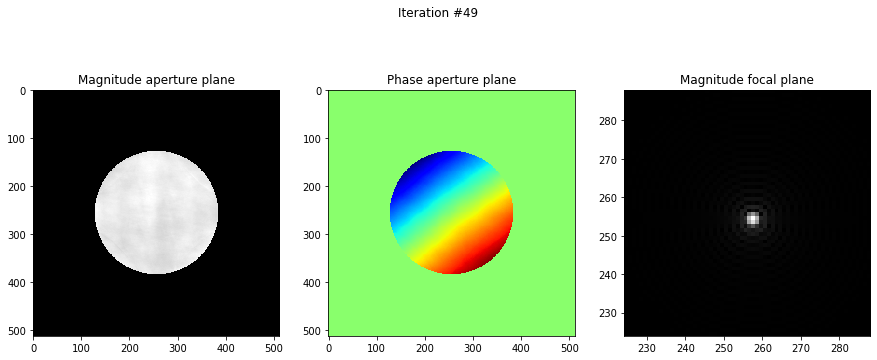

In [22]:
from IPython import display

for loop in range(nloops):
    
    # Calculate the field at the aperture from the focal plane
    # using Fraunhofer (ifft2). May need np.fft.ifftshift to undo
    # the previously applied np.fft.fftshift (see variable `field_screen` above)
    field_aperture = np.fft.ifft2(np.fft.ifftshift(field_focal_plane))

    # Enforce the support constraint in the aperture plane
    # i.e. zero all the points outside the known extent of the aperture
    field_aperture = field_aperture * aperture

    # Calculate the error in the aperture plane as the
    # difference between the amplitudes within the aperture:
    errors_aperture[loop] = np.sum((np.abs(field_aperture) - aperture)**2)

    # Calculate the field at the focal plane from the aperture plane
    # using Fraunhofer (fft2). May need an fftshift here!
    field_focal_plane = np.fft.fftshift(np.fft.fft2(field_aperture))

    # Calculate the error in the focal plane as the
    # difference between the estimated magnitude and known magnitude
    errors_focal[loop] = np.sum((np.abs(field_focal_plane) - magnitude_focal_plane)**2)
    
    # Enforce the magnitude constraint at the focal plane.
    # Do so by combining the phase of `focal_plane_field` with the known magnitude
    field_focal_plane = magnitude_focal_plane * np.exp(1j * np.angle(field_focal_plane))
    
    plt.figure(figsize=(15, 6))
    display.clear_output(wait=True)
    
    # Plot the results from the current iteration:
    plt.suptitle('Iteration #%02d' % loop)
    plt.subplot(131)
    plt.title('Magnitude aperture plane')
    plt.imshow(np.abs(field_aperture), cmap='gray')
    plt.subplot(132)
    plt.title('Phase aperture plane')
    plt.imshow(np.angle(field_aperture) * aperture, cmap='jet')
    plt.subplot(133)
    plt.title('Magnitude focal plane')
    plt.imshow(np.abs(field_focal_plane)[left:right, left:right],
               extent=(left, right, left, right))
    
    # Pause between iteration steps so you can see the incremental change:
    if loop < 10:
        plt.pause(0.5)
    else:
        plt.pause(0.001)

Plot the figures and compare with the lecture slides. We see that the aperture phase converged nicely, while the aperture magnitude has some remaining cloudy variations. 

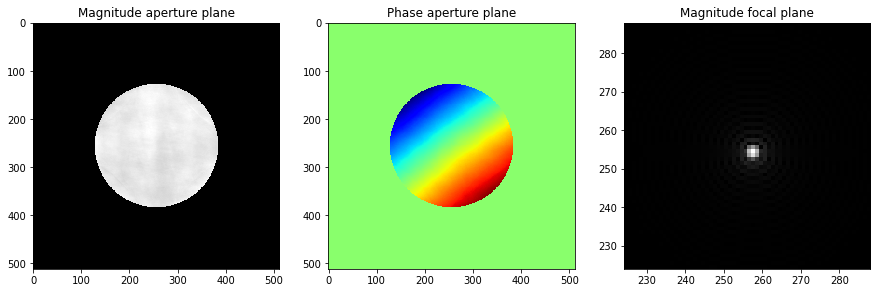

In [23]:
plt.figure(figsize=(15, 6))
plt.subplot(131)
plt.title('Magnitude aperture plane')
plt.imshow(np.abs(field_aperture) * aperture)

plt.subplot(132)
plt.title('Phase aperture plane')
plt.imshow(np.angle(field_aperture) * aperture, cmap='jet')

plt.subplot(133)
plt.title('Magnitude focal plane')
plt.imshow(np.abs(field_focal_plane)[left:right, left:right],
           extent=(left, right, left, right))

Look at the evolution of the error in aperture and focal plane. At first the descent is very steep but it flattens out over time. You can see from the remaining slope that we are not fully converged yet, but for the visual quality in the scope of this exercise it's sufficient.

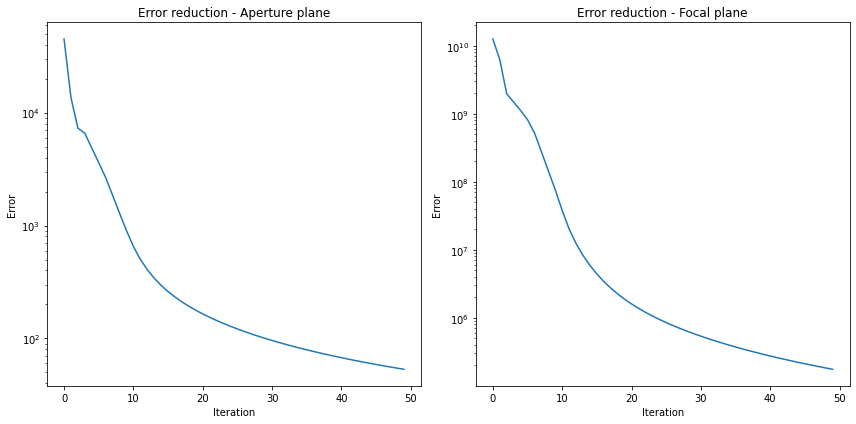

In [24]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.semilogy(errors_aperture)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Error reduction - Aperture plane')

plt.subplot(122)
plt.semilogy(errors_focal)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Error reduction - Focal plane')

plt.tight_layout()

## Part 3: Beam block

With a real detector we could not measure the far-field intensity directly because the central peak is very bright. Instead we place a beam block in the center, blocking the bright spot. 

This prevents us from using the information in the center. After adapting the optimization algorithm, we will see that we can still reconstruct the aperture magnitude and phase. 

The bright spot is not perfectly in the center in our example. Why?   
(Hint: Look at the aperture phase and think of last week's exercise about far field propagation ;-) )

First, we emulate the measured intensity with a beam block in the center. We choose a size of 5x5 pixels. Here, this size is quite arbitrary, but in reality we have to take 

1. the exposure time 
2. the dynamic range of our detector 
3. the necessary frequency region to recover our sample 

into account. (3) is interesting, as we are effectively blocking the low frequency information. For realistic samples, we expect the visual information to be represented mainly in the medium frequency range.

Define an NxN array which blocks the central 5x5 pixels:

In [25]:
blocksize = 5
beam_block = np.ones((N, N))
beam_block[N//2 - blocksize//2 : N//2 - blocksize//2 + blocksize,
           N//2 - blocksize//2 : N//2 - blocksize//2 + blocksize] = 0

intensity_focal_plane_block = beam_block * intensity_focal_plane

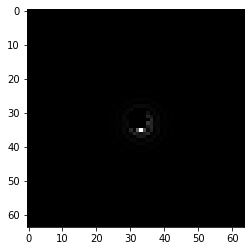

In [26]:
plt.figure()
plt.imshow(intensity_focal_plane_block[left:right, left:right])

We have to increase the number of iterations, because the convergence with a beam block is slower.

Otherwise, create the initial arrays same as before.

In [27]:
nloops = 200

magnitude_focal_plane_block = np.sqrt(intensity_focal_plane_block)
field_focal_plane_block = magnitude_focal_plane_block * np.exp(1.j * np.zeros((N, N)))

errors_aperture_block = np.zeros(nloops)
errors_focal_block = np.zeros(nloops)

We perform the same retrieval algorithm as before, but we have to pay attention to applying the focal plane constraint correctly: 

We want to apply the focal plain constraint only where have actual information. Where we blocked the beam in the center, we have measured 0's, but we don't enforce those 0's on the propagated field at focal plane. 

For us, this means we only write the focal plane magnitude where `beam_block` is `1`. You can achieve this with the `np.where` function. Look at its docstring. `condition` is where `beam_block` is `1`, `x` is our precomputed focal plane magnitude constraint and `y` is the propagated wave before applying the constraint.

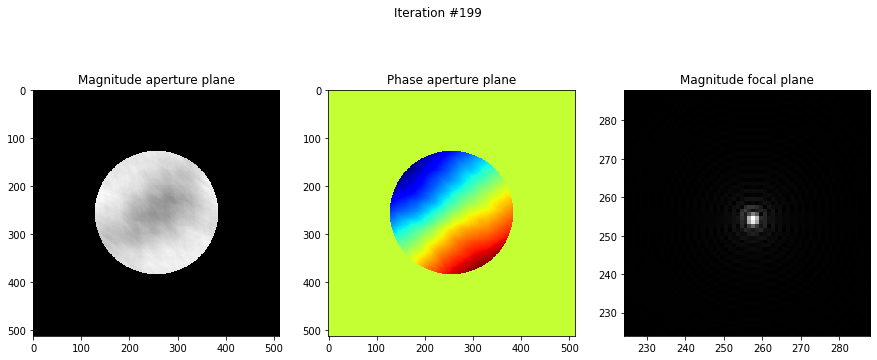

In [28]:
for loop in range(nloops):
    
    # Calculate the field at the aperture from the focal plane
    # Unchanged
    field_aperture_block = np.fft.ifft2(np.fft.ifftshift(field_focal_plane_block))

    # Enforce the support constraint in the aperture plane
    # Unchanged
    field_aperture_block = field_aperture_block * aperture

    # Calculate the error in the aperture plane as the
    # Unchanged
    errors_aperture_block[loop] = np.sum((np.abs(field_aperture_block) - aperture)**2)

    # Calculate the field at the focal plane from the aperture plane
    # Unchanged
    field_focal_plane_block = np.fft.fftshift(np.fft.fft2(field_aperture_block))

    # Calculate the error in the focal plane as the
    # Change: Ignore error inside beam block
    errors_focal_block[loop] = np.sum(beam_block * (np.abs(field_focal_plane_block) - magnitude_focal_plane_block)**2)
    
    # Enforce the magnitude constraint at the focal plane.
    # Change: Don't enforce magnitude = 0 inside beam block. 
    magn_constraint = np.where(beam_block == 1, magnitude_focal_plane_block, np.abs(field_focal_plane_block))
    field_focal_plane_block = magn_constraint * np.exp(1j * np.angle(field_focal_plane_block))
    
    
    plt.figure(figsize=(15, 6))
    display.clear_output(wait=True)
    
    # Plot the results from the current iteration:
    plt.suptitle('Iteration #%02d' % loop)
    plt.subplot(131)
    plt.title('Magnitude aperture plane')
    plt.imshow(np.abs(field_aperture_block), cmap='gray')
    plt.subplot(132)
    plt.title('Phase aperture plane')
    plt.imshow(np.angle(field_aperture_block) * aperture, cmap='jet')
    plt.subplot(133)
    plt.title('Magnitude focal plane')
    plt.imshow(np.abs(field_focal_plane_block)[left:right, left:right],
               extent=(left, right, left, right))
        
    plt.pause(0.001)

We see the optimization takes a lot longer due to the missing low frequency features, but after 200 iterations the result looks pretty similar to the ground truth.

Keep in mind that this a particularly hard example: The signal we want to recover mostly consists of low frequencies. It represents a reference scan without a sample, to obtain the "intrinsic" phase of the setup.

Let's look at the evolution of the errors.

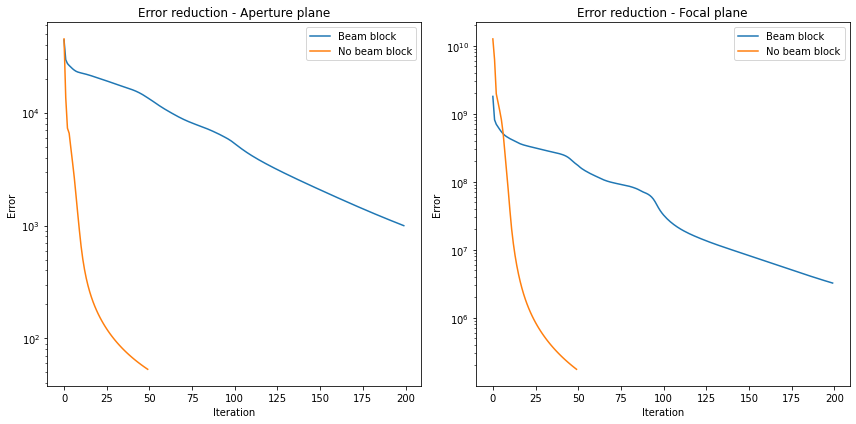

In [29]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.semilogy(errors_aperture_block, label="Beam block")
plt.semilogy(errors_aperture, label="No beam block")
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Error reduction - Aperture plane')
plt.legend()

plt.subplot(122)
plt.semilogy(errors_focal_block, label="Beam block")
plt.semilogy(errors_focal, label="No beam block")
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Error reduction - Focal plane')
plt.legend()

plt.tight_layout()

We see that the curve is a still very steep after 200 iterations, so we have definitely not reached convergence. If you are interested, try running with more iterations!

Finally, let's compare the result to the first run without the beam block. Despite the visual similarity the error is still large. This is due to the slower convergence; for enough iterations the results should look almost the same.

Text(0.5, 1.0, 'Absolute error')

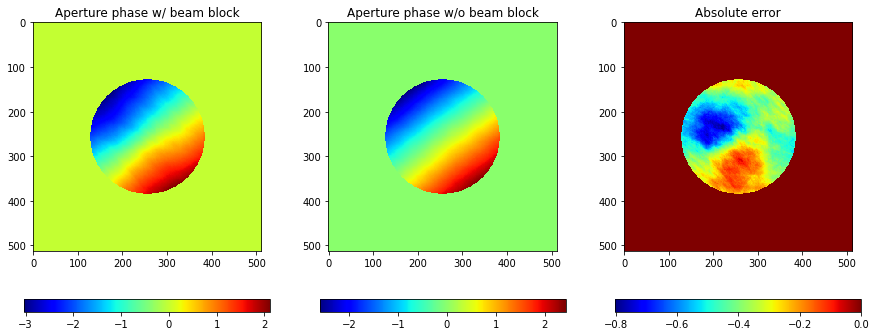

In [30]:
plt.figure(figsize=(15, 6))

plt.subplot(131)
plt.imshow(np.angle(field_aperture_block) * aperture, cmap='jet')
plt.colorbar(orientation="horizontal")
plt.title("Aperture phase w/ beam block")

plt.subplot(132)
plt.imshow(np.angle(field_aperture) * aperture, cmap='jet')
plt.colorbar(orientation="horizontal")
plt.title("Aperture phase w/o beam block")

plt.subplot(133)
plt.imshow((np.angle(field_aperture_block) - np.angle(field_aperture))* aperture, cmap='jet')
plt.colorbar(orientation="horizontal")
plt.title("Absolute error")